# Angular Correlations of Amorphous Materials

This notebook demonstrates caclulating the angular correlation of transmission electron diffraction patterns. The example patterns were recorded from an amorphous material, but the same calculations will work for crystalline materials as well.

The dataset used for this demonstration is a 4-D STEM dataset of a PdCuSi metallic glass thin film aquired using a DE-16 Camera on a 200 kV FEI Titan electron microscope at 100 fps.  The probe size was ~2 nm and step size was 0.365 nm so there there is singificant probe overlap in the probe positions.

This functionality has been checked to run with pyxem-0.13.2 (May 2021). However, bugs are always possible! Do not trust the code blindly, and please report issues here: https://github.com/pyxem/pyxem-demos/issues

## Background

Angular correlations are sensitive to rotational symmetry of the strucuture illuminated by the beam. Angular correlations computed from a spatially-resolved 4D STEM dataset provide spatial maps of regions with particular rotational symmetry.  

The angular correlation function is defined as the angular-autocorrelation of a diffraction pattern $I(k, \theta)$, where $(k, \theta)$ are polar coordinates in the diffraction plane. 

<p style="text-align: center;">
$ C(k,\phi) = \frac{\langle I(k, \theta) \cdot I(k, \theta+\phi)\rangle_\theta - \langle I(k,\theta)\rangle^2_\theta }{\langle I(k, \theta)\rangle^2_\theta} $,</p>

where $\langle \rangle_\theta$ indicates averaging over $\theta$.


## Contents

1. <a href='#loa'> Importing & Visualization</a>
2. <a href='#s2'> Polar Reprojection</a>
3. <a href='#s3'> Angular Correlation</a>
4. <a href='#s4'> Power Spectrum and Correlation Maps</a>

<a id='s1'></a> 

## 1 - Importing and Visualization

This section goes over loading the data from the data folder and visualizing the data for further use. 

In [1]:
data_path = "data/09/PdNiP_test.hspy"

In [2]:
%matplotlib inline
import pyxem as pxm
import hyperspy.api as hs
import hyperspy

/home/carter/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/carter/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [3]:
# Checking the package versions... 
try:
    assert(float(hyperspy.__version__[0:3])==1.6)
except(AssertionError):
    print("Hyperspy must be version 1.6 or higher for this  notebook to work.  Please refer to the installation"
         "instructions for how to install or reinstall hyperspy")
    
try:
    assert(float(pxm.__version__[0:4])==0.13)
except(AssertionError):
    print("Pyxem must be version 0.13 or higher for this  notebook to work.  Please refer to the installation"
         "instructions for how to install or reinstall pyxem")

In [4]:
pxm.__version__

'0.13.3'

In [5]:
data = hs.load("ac_data/PdNiP_test.hspy")

<a id='s2'></a> 

##  2 - Polar Conversion
 
This section deals with converting the $I(k_x, k_y)$ Cartesian signal to a $I(k, \theta)$ polar signal. Even small ellpitical distortion of the pattern or mistakes in finding the center of the diffraction pattern will degrade the quality of the $C(k, \phi)$ data and in some cases will introduce non-structural artifacts.

There is still some ongoing development of methods for identifying and correcting for distortions, but a good check is always to ensure that the first amorphous ring is a line in the polar representation of the data after correction. Small splitting in $k$ of peaks in $C(k, \phi)$ is often an indication of incorrect pattern centering.

In [6]:
data.set_signal_type("electron_diffraction")
data.beam_energy=200
data.unit = "k_nm^-1"


In [7]:
mask =data.get_direct_beam_mask(20)

In [8]:
# Affine correction from fitting an ellipse
import numpy as np
center=(31.2,31.7)
affine=np.array([[ 1.03725511, -0.02662789,  0.        ],
                 [-0.02662789,  1.01903215,  0.        ],
                 [ 0.        ,  0.        ,  1.        ]])

In [9]:
data.set_ai(center=center)
rad = data.get_azimuthal_integral2d(npt=100)

**Note:** This isn't perfect, as there is still some distortion that an affine transformation could fix, but for the purposes of this demo, it will suffice.

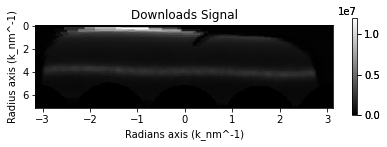

In [10]:
rad.sum().plot()

<a id='s3'></a>

##   3 - Angular Correlations
 
This section deals with converting the polar intensity to a correlation function.  If the data contain a beam stop, masking the beam stop is an important part of this calculation. Otherwise, the computed correlation will be dominated by the beam stop, not the sample scattering.


First we will define a mask based on the summed diffraction pattern.

In [11]:
summed = rad.sum()
mask = ((summed>4e6)+(summed<3e5))

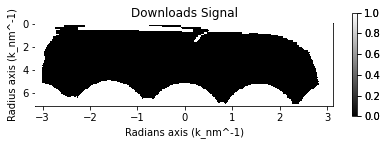

In [12]:
mask.plot()

### Calculating the Angular Correlation

The angular correalation can be calculated using the `get_angular_correlation()` function which optionally takes a mask if you have something like a beamstop. 

In [13]:
cor = rad.get_angular_correlation(mask=mask)

### Visualizing the Angular Correlation

We can look at the angular correlations by plotting the relevent `cor` signal.  In this case we only are looking at the region from k = 1 nm$^{-1}$ to k = 5 nm $^{-1}$ which we can select using the `isig` function to slice the dataset. 

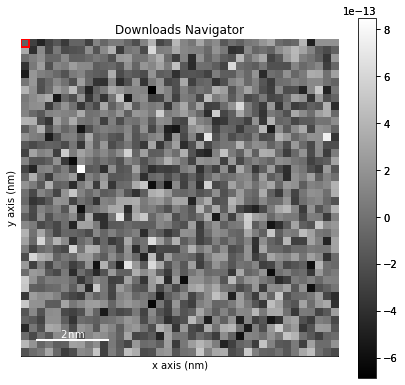

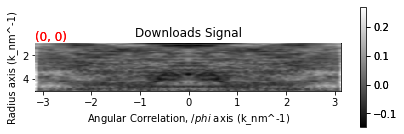

In [14]:
cor.isig[:,1.0:5.0].plot()

<a id='s4'></a>

##   4 - Power Spectrum and Correlation Maps
 
This section deals with visualization of correlation maps computed from 4D STEM data.  These iamges are spatial maps of the magnitude of a particular order of rotational symmetry in the material.

The power spectrum is calculated by taking the FFT of the Angular correlation.  This divides the angular correlation into channels where each fourier channel is associated with some symmetry. 

In [15]:
power = cor.get_angular_power()

### Visualizing the Power Spectrum

Below is the power spectrum for the entire dataset. This helps to interpurt the dominate symmetries in the angular correlation. 

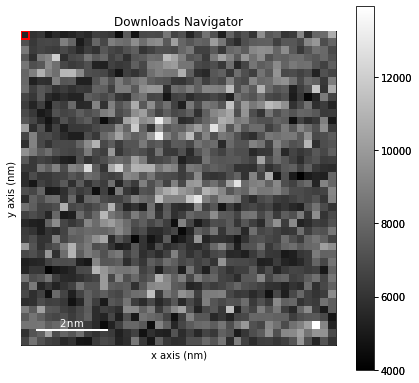

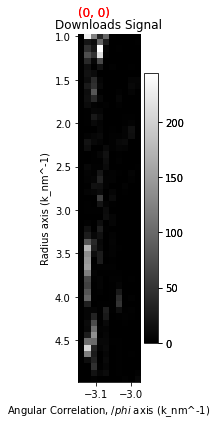

In [16]:
power.isig[0:10,1.0:5.0].plot()

### Spatial Maps of Symmetry

Calling the `plot_symmetries` function plots the spatial maps of the symmetries for some dataset.  Below we can the same region multiple times with reconstructed images from the power spectrum.  Here we see the region from k=3.0-4.5 nm $^{-1} summed for each of the labeled fourier coefficeints. 

The bright regions are local clusters in the glass with the symmetry listed above. 

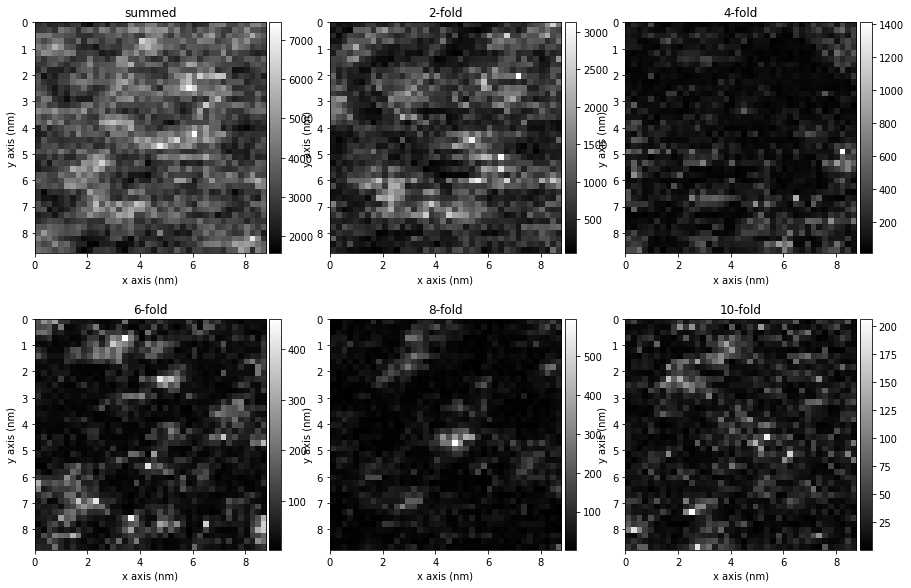

In [17]:
import matplotlib.pyplot as plt
f = plt.figure(figsize=(15,10))
power.plot_symmetries(k_region = [3.,4.5],fig=f)